In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def load_image_grayscale(path):
    img = Image.open(path).convert('L')  # Convert to grayscale
    img_np = np.array(img).astype(np.float32) / 255.0  # Normalize to [0, 1]
    return img_np

In [4]:
def compute_fft2(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    return fshift

In [5]:
def generate_circular_masks(shape, grid_size, radius, overlap=0.15):
    H, W = shape
    masks = []
    cx, cy = W // 2, H // 2  # center of frequency domain

    spacing = 2 * radius * (1 - overlap)

    x_lin = np.linspace(cx - (grid_size[1] - 1) / 2 * spacing,
                        cx + (grid_size[1] - 1) / 2 * spacing,
                        grid_size[1])
    y_lin = np.linspace(cy - (grid_size[0] - 1) / 2 * spacing,
                        cy + (grid_size[0] - 1) / 2 * spacing,
                        grid_size[0])
    xv, yv = np.meshgrid(x_lin, y_lin)

    Y, X = np.ogrid[:H, :W]
    centers = []

    # Restore original loop order: for each y (row), loop over x (column)
    for i in range(grid_size[0]):  # rows (y)
        for j in range(grid_size[1]):  # columns (x)
            center_x, center_y = int(round(xv[i, j])), int(round(yv[i, j]))
            mask = (X - center_x)**2 + (Y - center_y)**2 <= radius**2
            masks.append(mask.astype(np.float32))
            centers.append([center_x - cx, -(center_y - cy)])

    centers_px = np.array(centers, dtype=np.int32)[None, :, :]  # (1, N, 2)

    return masks, centers_px


In [6]:
def apply_mask_to_fft(fft_image, mask):
    return fft_image * mask

In [7]:
def compute_ifft2(fft_masked):
    f_ishift = np.fft.ifftshift(fft_masked)
    img_back = np.fft.ifft2(f_ishift)
    return np.abs(img_back)

In [8]:
def show_image_and_spectrum(image, fft_image, title_prefix=""):
    magnitude_spectrum = np.log1p(np.abs(fft_image))

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'{title_prefix}Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title(f'{title_prefix}FFT Magnitude')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [9]:
def visualize_masks_overlay(fft_image, masks, alpha=0.3):
    base = np.log1p(np.abs(fft_image))
    combined_mask = np.zeros_like(base)

    for mask in masks:
        combined_mask += mask

    plt.figure(figsize=(6, 6))
    plt.imshow(base, cmap='gray')
    plt.imshow(combined_mask, cmap='jet', alpha=alpha)
    plt.title("Circular Mask Grid Overlay")
    plt.axis('off')
    plt.show()

In [10]:
def display_low_res_images(images, grid_size):
    rows, cols = grid_size
    fig, axs = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            axs[i, j].imshow(images[idx], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title(f'Patch ({i},{j})')
    plt.tight_layout()
    plt.show()


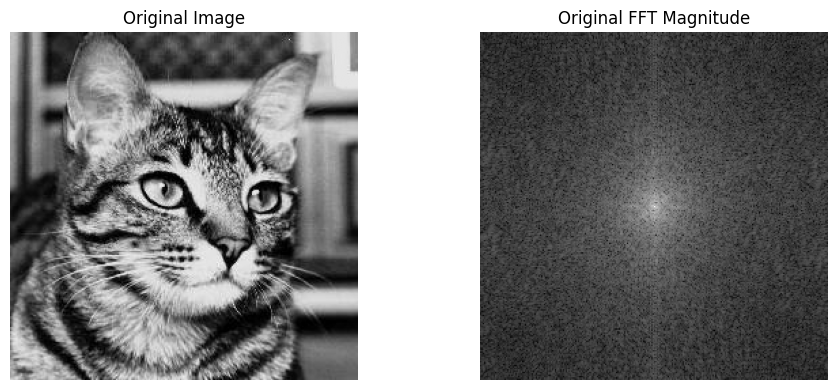

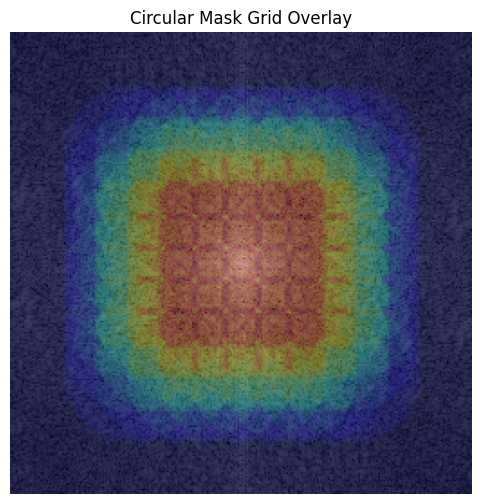

In [20]:
# Load and process image
img = load_image_grayscale(r'C:\Users\beery\OneDrive\桌面\Study\SoSe 2025 Jena\Imip\IMIP-Project\FP_Yen\cat.jpg')
fshift = compute_fft2(img)

# Show original and spectrum
show_image_and_spectrum(img, fshift, title_prefix="Original ")

# Create masks
grid_size = (8, 8)
radius = 38
masks, Ns = generate_circular_masks(img.shape, grid_size, radius, overlap=0.77)

# Visualize masks on spectrum
visualize_masks_overlay(fshift, masks)


In [21]:
# Apply masks and inverse FFT
low_res_images = []
Ns_index = 0
for mask in masks:
    masked_fft = apply_mask_to_fft(fshift, mask)
    low_res = compute_ifft2(masked_fft)
    low_res_images.append(low_res)

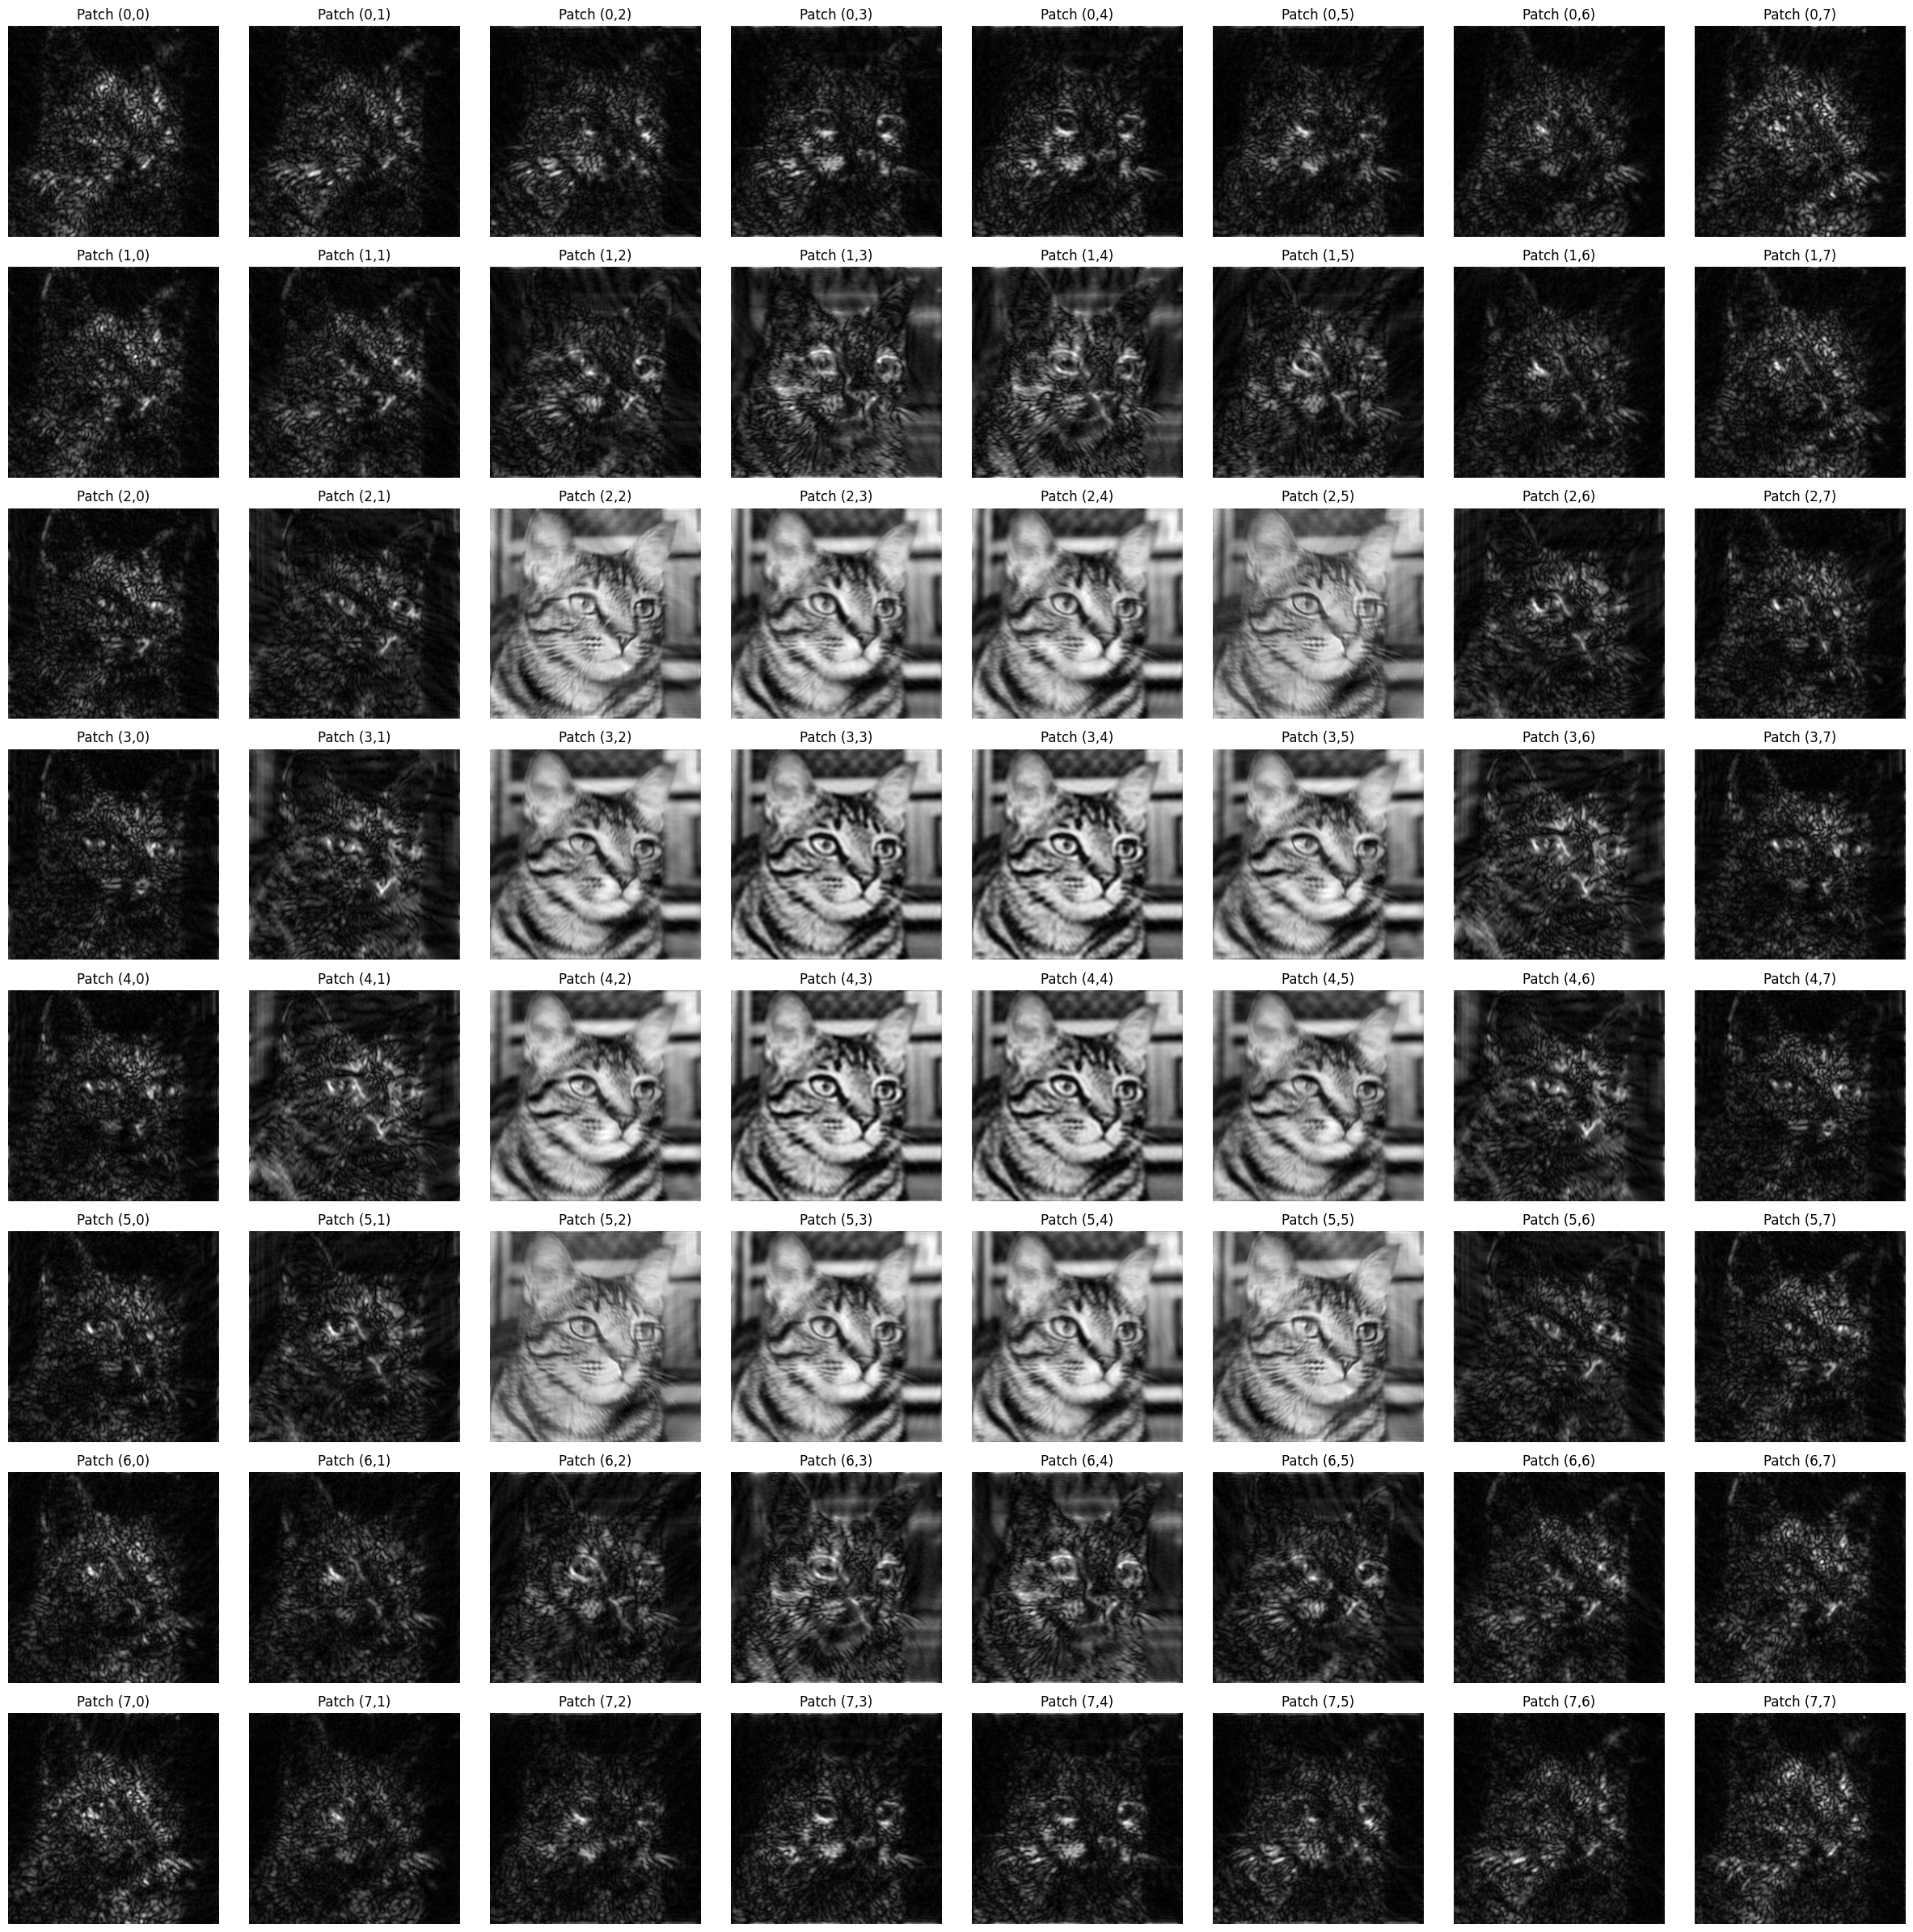

In [22]:
# Display reconstructed images
display_low_res_images(low_res_images, grid_size)

In [23]:
stacked_images = np.stack(low_res_images, axis=-1)
stacked_images.shape

(256, 256, 64)

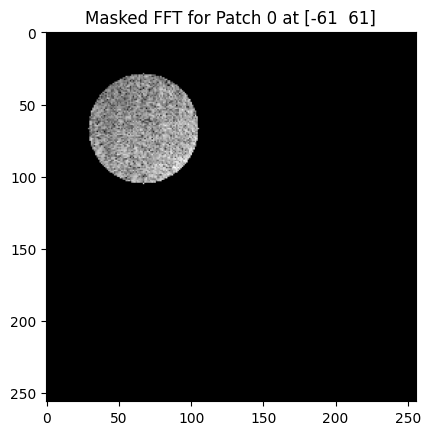

In [24]:
# Sanity check: ensure the Ns and masked_fft match
check_index = 0  # Example index to check
masked_fft = apply_mask_to_fft(fshift, masks[check_index])
plt.imshow(np.log1p(np.abs(masked_fft)), cmap='gray')
plt.title(f'Masked FFT for Patch {check_index} at {Ns[0, check_index]}') # Display the center coordinates for the selected mask
plt.show()

In [25]:
%load_ext autoreload
%autoreload 2
import Main_functions
from Main_functions import AlterMin

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


| iter |  rmse    |
--------------------
|  0   | inf |
|  1   | 3.81e+07 |
|  2   | 1.01e+07 |
|  3   | 2.70e+06 |
|  4   | 1.29e+06 |
|  5   | 7.60e+05 |
|  6   | 5.02e+05 |
|  7   | 3.58e+05 |
|  8   | 2.70e+05 |
|  9   | 2.12e+05 |
| 10   | 1.72e+05 |
| 11   | 1.45e+05 |
| 12   | 1.25e+05 |
| 13   | 1.11e+05 |
| 14   | 1.01e+05 |
| 15   | 9.40e+04 |
| 16   | 8.97e+04 |
| 17   | 8.80e+04 |
| 18   | 8.88e+04 |


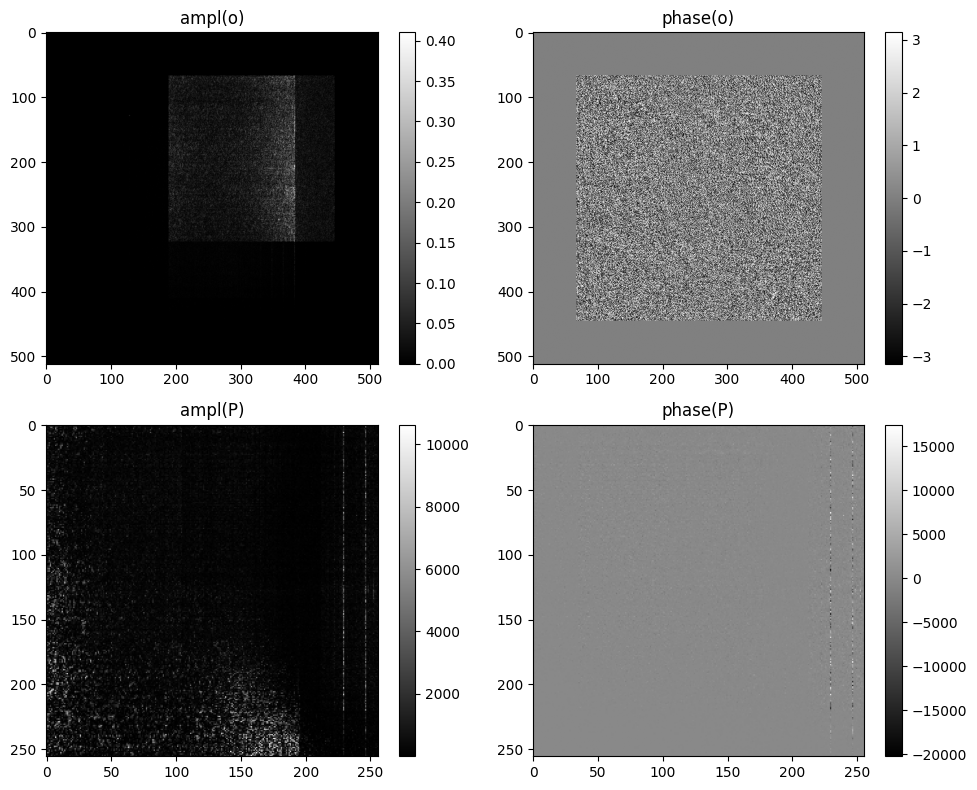

elapsed time: 30 seconds


In [29]:
# Stepsize 0.01
# Alpha Beta are both 3
O, P, err, scale, Ns = AlterMin(stacked_images, [512,512], Ns, {})

Text(0.5, 1.0, 'Optimized Image')

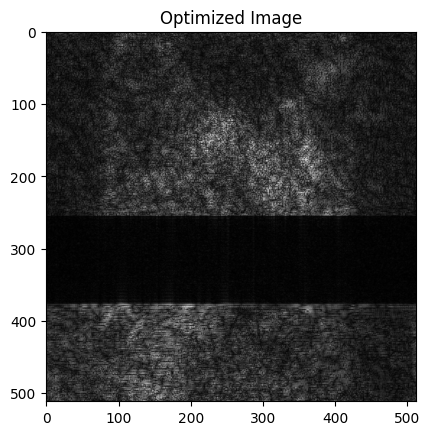

In [31]:
o_image=np.fft.ifft2(O)
plt.imshow(np.abs(o_image), cmap='gray')
# Display the optimized image
plt.title("Optimized Image")